# Pruebas de procesamiento de frames. Estadisticas

In [1]:
import cv2
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Carga fichero de ejemplo

In [152]:
image_file="output/20201024013813_ZWO_ASI294MC_Pro.fit"
#image_file="output1/20201024011228_ZWO_ASI294MC_Pro.fit"
#image_file='output/20201024013756_ZWO_ASI294MC_Pro.fit'

In [153]:
image_data = fits.getdata(image_file, ext=0)
image_data = image_data.byteswap().newbyteorder()
print(image_data.shape)

(2822, 4144)


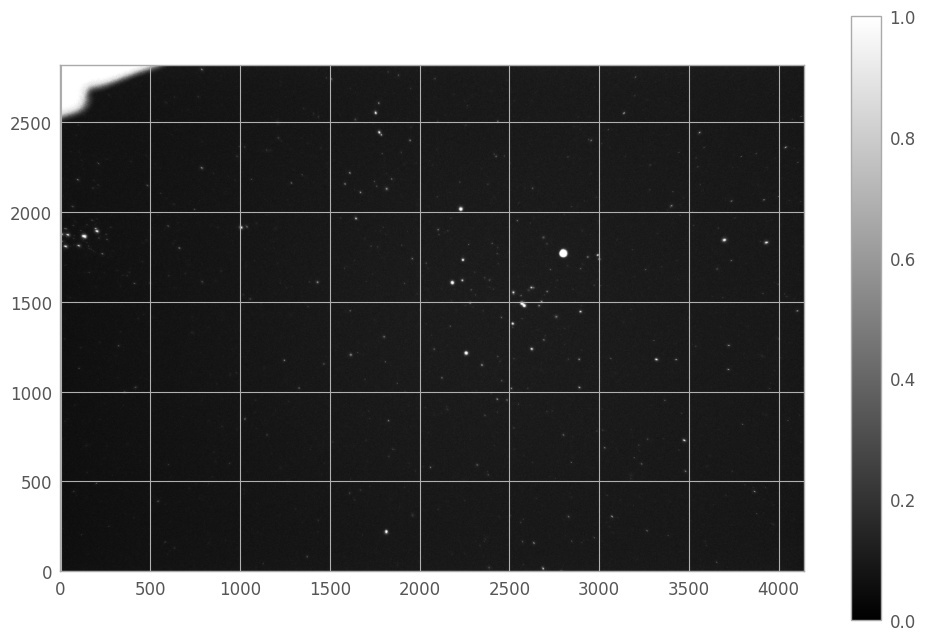

In [154]:
plt.figure()
plt.imshow(image_data, cmap='gray',origin='lower')
plt.colorbar()

### Extraccion de fondo y fuentes con SEP

In [155]:
import sep

In [156]:
bkg = sep.Background(image_data,bw=64,bh=64)

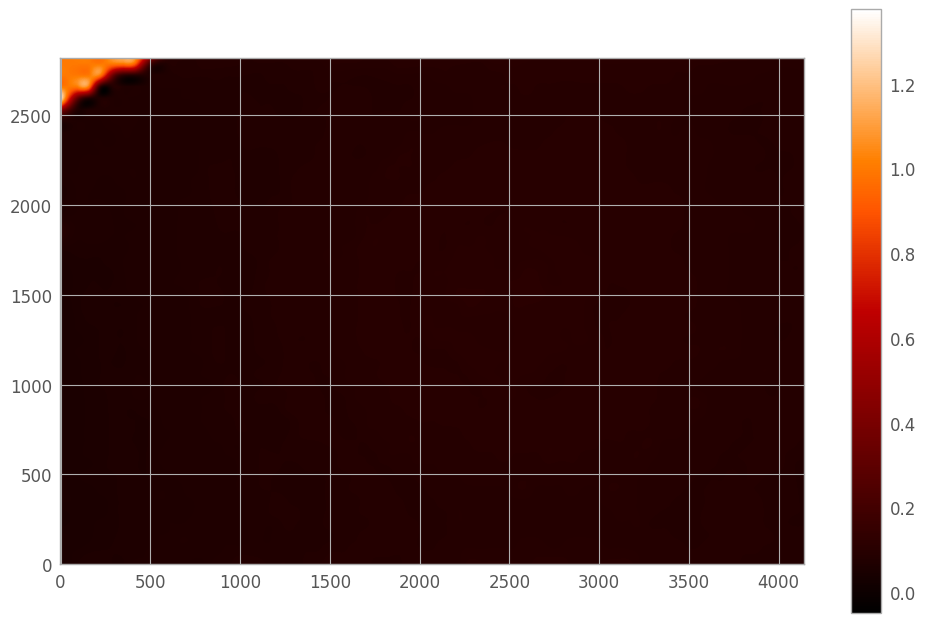

In [157]:
# show the background
plt.imshow(bkg, origin='lower')
plt.colorbar();

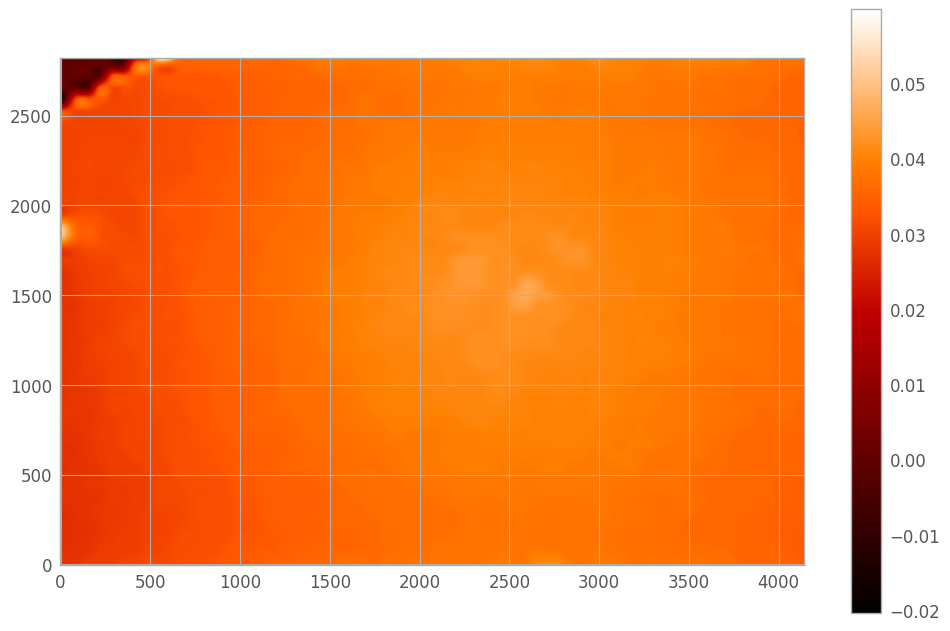

In [158]:
plt.imshow(bkg.rms(),origin='lower')
plt.colorbar();

In [159]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
print((mean, median, std)) 

(0.09322449696439074, 0.09019607843137255, 0.038697485887834664)


In [160]:
print(np.mean(image_data),np.median(image_data),bkg.globalback,bkg.globalrms)

0.10098586722408989 0.09019607843137255 0.08829350769519806 0.03738556057214737


In [161]:
from photutils import make_source_mask
mask = make_source_mask(image_data, nsigma=2, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, mask=mask)
print((mean, median, std)) 

(0.09210262800034495, 0.09019607843137255, 0.03828808146985361)


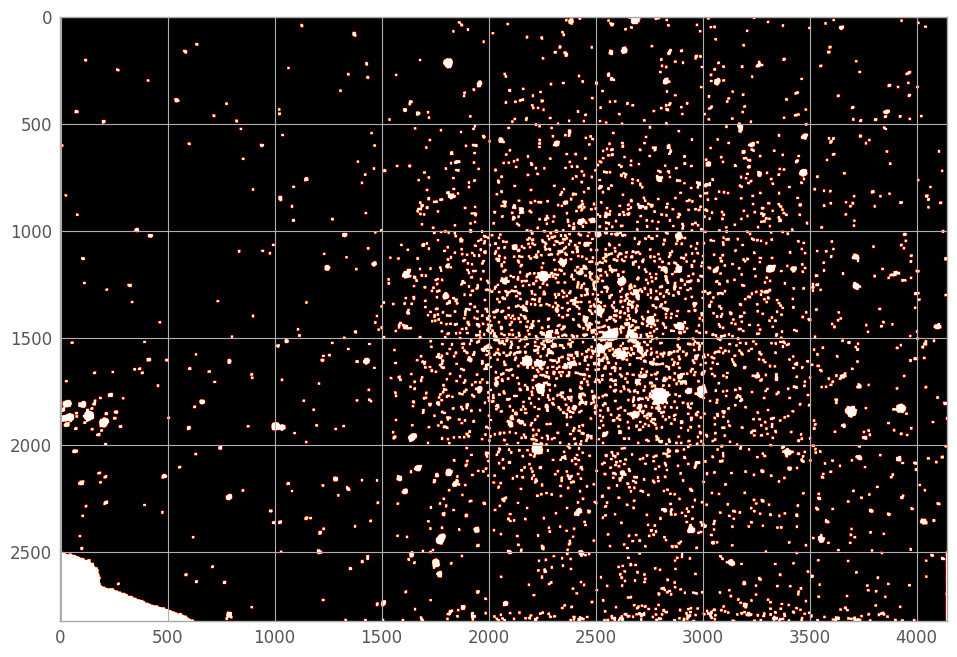

In [162]:
plt.imshow(mask)

In [163]:
thresh = 3 * bkg.globalrms
# subtract the background
data_sub = image_data - bkg
objects = sep.extract(data_sub, thresh)

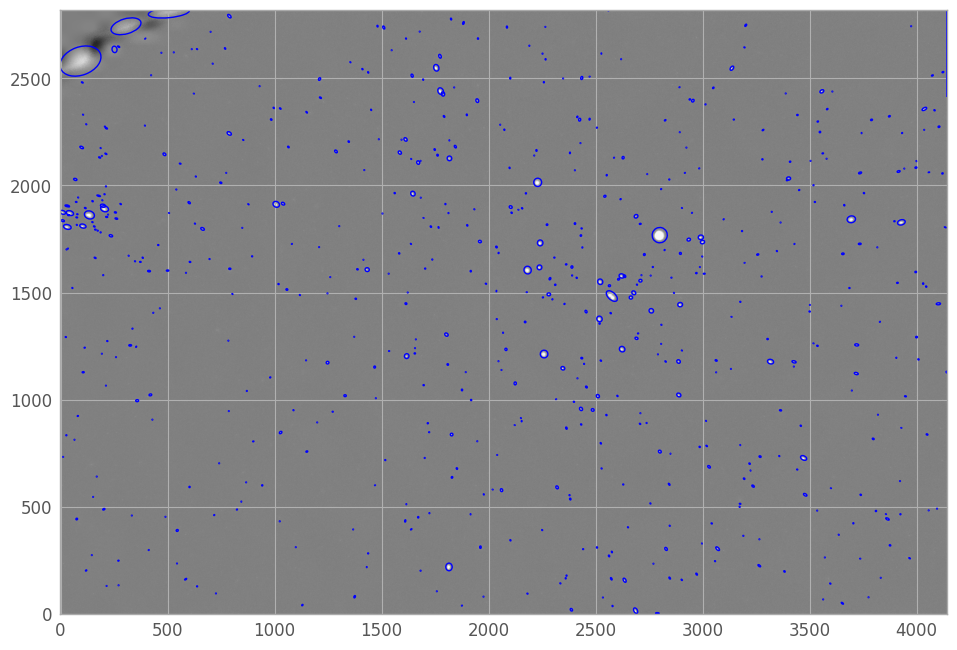

In [164]:
from matplotlib.patches import Ellipse
import numpy as np

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
#im = ax.imshow(data, interpolation='nearest', cmap='gray',
#               vmin=m-s, vmax=m+s, origin='lower')
im = ax.imshow(data_sub, cmap='gray', origin='lower')
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')
    ax.add_artist(e)

# FWHM para enfocar

In [165]:
def FWHM(objs):
    return 2 * np.sqrt(np.log(2)*(objs['x2'] + objs['y2']))

In [166]:
fwhm=FWHM(objects)

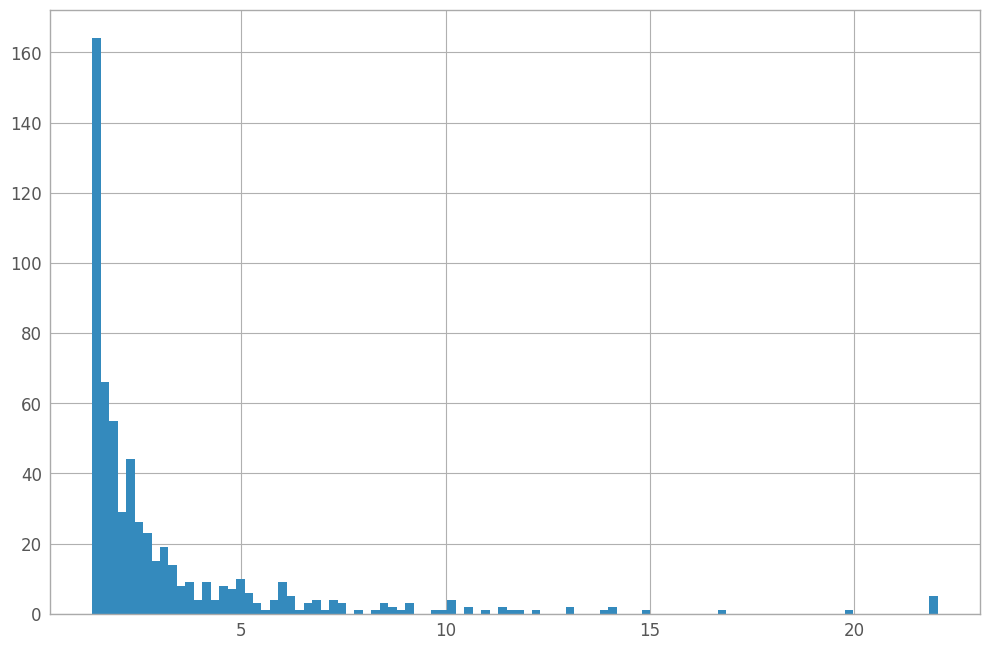

In [167]:
plt.hist(np.clip(fwhm,0,3*fwhm.std()),bins=100)
plt.show()

In [168]:
np.median(fwhm)

2.0726714516671594

In [169]:
np.mean(fwhm)

3.5396068190919645